**This notebook is an exercise in the [Computer Vision](https://www.kaggle.com/learn/computer-vision) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/data-augmentation).**

---


# Introduction #

In these exercises, you'll explore what effect various random transformations have on an image, consider what kind of augmentation might be appropriate on a given dataset, and then use data augmentation with the *Car or Truck* dataset to train a custom network.

Run the cell below to set everything up!

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex6 import *

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


2025-08-18 02:13:25.232693: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-18 02:13:25.232826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-18 02:13:25.394449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


# (Optional) Explore Augmentation #

Uncomment a transformation and run the cell to see what it does. You can experiment with the parameter values too, if you like. (The `factor` parameters should be greater than 0 and, generally, less than 1.) Run the cell again if you'd like to get a new random image.

In [ ]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    preprocessing.RandomFlip(mode='horizontal'), # meaning, top-to-bottom
    # preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    preprocessing.RandomRotation(factor=0.10),
    # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

Do the transformations you chose seem reasonable for the *Car or Truck* dataset?

In this exercise, we'll look at a few datasets and think about what kind of augmentation might be appropriate. Your reasoning might be different that what we discuss in the solution. That's okay. The point of these problems is just to think about how a transformation might interact with a classification problem -- for better or worse.

The [EuroSAT](https://www.kaggle.com/ryanholbrook/eurosat) dataset consists of satellite images of the Earth classified by geographic feature. Below are a number of images from this dataset.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/LxARYZe.png" width=600, alt="Sixteen satellite images labeled: SeaLake, PermanentCrop, Industrial, Pasture, Residential, and Forest.">
</figure>

# 1) EuroSAT #

What kinds of transformations might be appropriate for this dataset?

In [ ]:
# View the solution (Run this code cell to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

It seems to this author that flips and rotations would be worth trying first since there's no concept of orientation for pictures taken straight overhead. None of the transformations seem likely to confuse classes, however.


In [4]:
# Lines below will give you a hint 
#q_1.solution()

The [TensorFlow Flowers](https://www.kaggle.com/ryanholbrook/tensorflow-flowers) dataset consists of photographs of flowers of several species. Below is a sample.

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Mt7PR2x.png" width=600, alt="Sixteen images of flowers labeled: roses, tulips, dandelion, and sunflowers">
</figure>

# 2) TensorFlow Flowers #

What kinds of transformations might be appropriate for the TensorFlow Flowers dataset?

In [5]:
# View the solution (Run this code cell to receive credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

It seems to this author that horizontal flips and moderate rotations would be worth trying first. Some augmentation libraries include transformations of hue (like red to blue). Since the color of a flower seems distinctive of its class, a change of hue might be less successful. On the other hand, there is suprising variety in cultivated flowers like roses, so, depending on the dataset, this might be an improvement after all!



In [6]:
# Lines below will give you a hint 
#q_2.solution()

Now you'll use data augmentation with a custom convnet similar to the one you built in Exercise 5. Since data augmentation effectively increases the size of the dataset, we can increase the capacity of the model in turn without as much risk of overfitting.

# 3) Add Preprocessing Layers #

Add these preprocessing layers to the given model.

```
preprocessing.RandomContrast(factor=0.10),
preprocessing.RandomFlip(mode='horizontal'),
preprocessing.RandomRotation(factor=0.10),
```


In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

# Check your answer
q_3.check()


<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [8]:
# Lines below will give you a hint or solution code
#q_3.hint()
#q_3.solution()

Now we'll train the model. Run the next cell to compile it with a loss and accuracy metric and fit it to the training set.

Epoch 1/50


I0000 00:00:1755483242.973572     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 [==============================] - 27s 225ms/step - loss: 0.6703 - binary_accuracy: 0.5921 - val_loss: 0.6382 - val_binary_accuracy: 0.6195
Epoch 2/50
80/80 [==============================] - 7s 84ms/step - loss: 0.6728 - binary_accuracy: 0.5880 - val_loss: 0.6909 - val_binary_accuracy: 0.5787
Epoch 3/50
80/80 [==============================] - 7s 84ms/step - loss: 0.6834 - binary_accuracy: 0.5781 - val_loss: 0.6867 - val_binary_accuracy: 0.5775
Epoch 4/50
80/80 [==============================] - 7s 84ms/step - loss: 0.6819 - binary_accuracy: 0.5779 - val_loss: 0.6642 - val_binary_accuracy: 0.5779
Epoch 5/50
80/80 [==============================] - 7s 84ms/step - loss: 0.6993 - binary_accuracy: 0.5857 - val_loss: 0.6751 - val_binary_accuracy: 0.5761
Epoch 6/50
80/80 [==============================] - 7s 84ms/step - loss: 0.6853 - binary_accuracy: 0.5851 - val_loss: 0.6842 - val_binary_accuracy: 0.5833
Epoch 7/50
80/80 [==============================] - 7s 84ms/step - loss: 0.6789

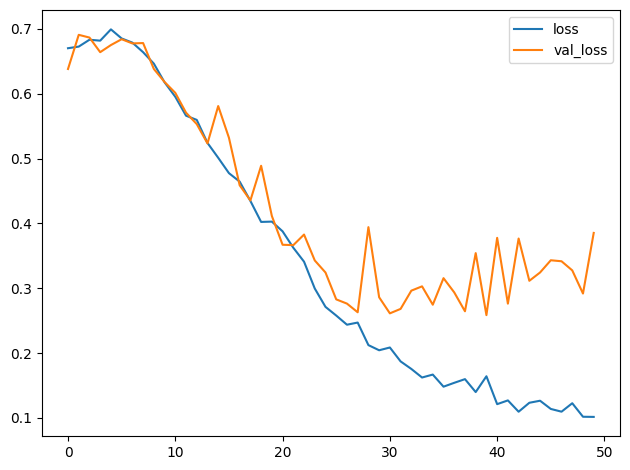

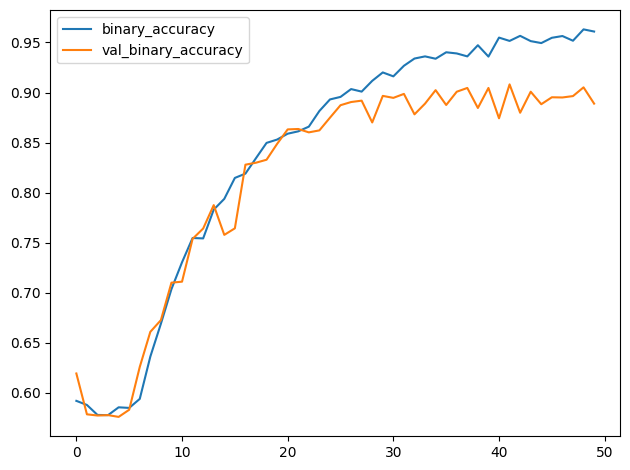

In [9]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

# 4) Train Model #

Examine the training curves. What there any sign of overfitting? How does the performance of this model compare to other models you've trained in this course?

In [10]:
# View the solution (Run this code cell to receive credit!)
q_4.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
The learning curves in this model stayed close together for much longer than in previous models. This suggests that the augmentation helped prevent overfitting, allowing the model to continue improving.

And notice that this model achieved the highest accuracy of all the models in the course! This won't always be the case, but it shows that a well-designed custom convnet can sometimes perform as well or better than a much larger pretrained model. Depending on your application, having a smaller model (which requires fewer resources) could be a big advantage.


# Conclusion #

Data augmentation is a powerful and commonly-used tool to improve model training, not only for convolutional networks, but for many other kinds of neural network models as well. Whatever your problem, the principle remains the same: you can make up for an inadequacy in your data by adding in "fake" data to cover it over. Experimenting with augmentations is a great way to find out just how far your data can go!

# The End #

That's all for **Computer Vision** on Kaggle Learn! Are you ready to apply your knowledge? Check out our two bonus lessons! They'll walk you through preparing a submission for a competition while you learn how to train neural nets with TPUs, Kaggle's most advanced accelerator. At the end, you'll have a complete notebook ready to extend with ideas of your own.
- [Create Your First Submission](https://www.kaggle.com/ryanholbrook/create-your-first-submission) - Prepare a submission for our *Petals to the Metal* Getting Started competition. You'll train a neural net to recognize over 100 species of flowers.
- [Cassava Leaf Disease](https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease) - Rather compete for money and medals? Train a neural net to diagnose common diseases in the cassava plant, a staple security crop in Africa.

Have fun learning!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/computer-vision/discussion) to chat with other learners.*